In [379]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

In [381]:
df = pd.read_csv("../../data/csv_files/df_ph1.csv")

In [383]:
df.head()

,dt,FEX_004,FSB_095DR,FSB_078,FSB_126,FSB_130D,FPZ_06A,FSB_079,FPZ_04A,FSB_097D
0,2023-07-28 05:00:00.000,3.979692,4.231642,4.162819,4.181472,4.128811,5.273175,7.715749,6.417295,3.767151
1,2023-07-28 06:00:00.000,3.980776,4.233550,4.163253,4.181599,4.129336,5.274380,7.713223,6.418118,3.767072
2,2023-07-28 07:00:00.000,3.980825,4.236443,4.163040,4.179049,4.129939,5.271060,7.712299,6.417948,3.767076
3,2023-07-28 08:00:00.000,3.981121,4.236699,4.166883,NaN,4.130379,5.267786,7.712222,6.417735,3.767253
4,2023-07-28 09:00:00.000,3.981221,4.239193,4.168008,NaN,4.130503,5.265711,7.712381,6.417951,3.767425


In [385]:
df.shape

(7748, 10)

In [387]:
df['dt'] = pd.to_datetime(df['dt'])

In [389]:
cols = list(df.columns)
cols.remove('dt')
cols

['FEX_004',
 'FSB_095DR',
 'FSB_078',
 'FSB_126',
 'FSB_130D',
 'FPZ_06A',
 'FSB_079',
 'FPZ_04A',
 'FSB_097D']

In [391]:
start_array = []
end_array = []
index = 3
start_na = True
print(cols[index])

for _, row in df.iterrows():
    if pd.isna(row[cols[index]]) and start_na:
        start_na = False
        start_array.append(row['dt'])
    elif not pd.isna(row[cols[index]]) and not start_na:
        start_na = True
        end_array.append(row['dt'])

FSB_126


In [393]:
print(len(start_array), len(end_array))

85 85


In [395]:
start_end = {}
for start, end in zip(start_array, end_array):
    start_end[start] = end
print(len(start_end))

85


In [397]:
length = {}
for start, end in start_end.items():
    length[(start, end)] = pd.to_datetime(end) - pd.to_datetime(start)
print(len(length))

85


In [399]:
na_data = {}
for key, duration in length.items():
    if duration > pd.Timedelta(days=1):
        na_data[key] = duration
print(len(na_data))

10


In [401]:
na_data

{(Timestamp('2023-07-28 08:00:00'),
  Timestamp('2023-07-31 13:00:00')): Timedelta('3 days 05:00:00'),
 (Timestamp('2023-07-31 14:00:00'),
  Timestamp('2023-08-03 22:00:00')): Timedelta('3 days 08:00:00'),
 (Timestamp('2023-08-04 07:00:00'),
  Timestamp('2023-08-08 04:00:00')): Timedelta('3 days 21:00:00'),
 (Timestamp('2023-08-09 11:00:00'),
  Timestamp('2023-08-13 16:00:00')): Timedelta('4 days 05:00:00'),
 (Timestamp('2023-08-13 20:00:00'),
  Timestamp('2023-08-19 05:00:00')): Timedelta('5 days 09:00:00'),
 (Timestamp('2023-08-19 09:00:00'),
  Timestamp('2023-08-21 19:00:00')): Timedelta('2 days 10:00:00'),
 (Timestamp('2023-08-23 20:00:00'),
  Timestamp('2023-08-28 16:00:00')): Timedelta('4 days 20:00:00'),
 (Timestamp('2023-08-28 17:00:00'),
  Timestamp('2023-08-31 07:00:00')): Timedelta('2 days 14:00:00'),
 (Timestamp('2023-08-31 22:00:00'),
  Timestamp('2023-10-18 14:45:00')): Timedelta('47 days 16:45:00'),
 (Timestamp('2024-01-01 01:00:00'),
  Timestamp('2024-01-24 14:06:00')):

In [403]:
new_df = df[df['dt'] >= "2024-01-24 17:00:00"]
print(new_df.shape)

(3390, 10)


In [405]:
new_df.head()

,dt,FEX_004,FSB_095DR,FSB_078,FSB_126,FSB_130D,FPZ_06A,FSB_079,FPZ_04A,FSB_097D
4358,2024-01-24 17:00:00,4.200342,4.336478,4.332603,4.391724,4.334914,NaN,7.767760,7.494180,3.997277
4359,2024-01-24 18:00:00,4.199731,4.336892,4.328062,4.392499,4.335384,5.250169,7.768929,7.495040,3.997087
4360,2024-01-24 19:00:00,4.200343,4.336161,4.327713,4.392068,4.335722,5.256137,7.768003,7.493386,3.996909
4361,2024-01-24 20:00:00,4.200376,4.336316,4.328190,4.391214,4.335845,5.261071,7.767725,7.497791,3.997079
4362,2024-01-24 21:00:00,4.201028,4.335628,4.327332,4.389647,4.335733,5.264223,7.767564,7.495985,3.997174


In [407]:
new_df.isna().sum()

dt             0
FEX_004       21
FSB_095DR     21
FSB_078       21
FSB_126       32
FSB_130D      21
FPZ_06A       22
FSB_079       21
FPZ_04A       21
FSB_097D     186
dtype: int64

In [409]:
df_interpolate = new_df.copy()
cols

['FEX_004',
 'FSB_095DR',
 'FSB_078',
 'FSB_126',
 'FSB_130D',
 'FPZ_06A',
 'FSB_079',
 'FPZ_04A',
 'FSB_097D']

In [411]:
for col in cols:
    df_interpolate[col] = df_interpolate[col].interpolate()

In [413]:
df_interpolate.isna().sum()

dt           0
FEX_004      0
FSB_095DR    0
FSB_078      0
FSB_126      0
FSB_130D     0
FPZ_06A      1
FSB_079      0
FPZ_04A      0
FSB_097D     0
dtype: int64

In [415]:
dummy_df = df_interpolate[df_interpolate["FPZ_06A"].isna()]
dummy_df

,dt,FEX_004,FSB_095DR,FSB_078,FSB_126,FSB_130D,FPZ_06A,FSB_079,FPZ_04A,FSB_097D
4358,2024-01-24 17:00:00,4.200342,4.336478,4.332603,4.391724,4.334914,NaN,7.76776,7.49418,3.997277


In [417]:
df_interpolate = df_interpolate.dropna()

In [419]:
test_df = df_interpolate.drop(columns = ["dt"])
test_df.shape

(3389, 9)

In [421]:
print(test_df.shape)
test_df.isna().sum()

(3389, 9)


FEX_004      0
FSB_095DR    0
FSB_078      0
FSB_126      0
FSB_130D     0
FPZ_06A      0
FSB_079      0
FPZ_04A      0
FSB_097D     0
dtype: int64

In [423]:
scaler = StandardScaler()
normalized_df = scaler.fit_transform(test_df)

In [425]:
normalized_df.shape

(3389, 9)

In [427]:
tensor_data = torch.tensor(normalized_df, dtype=torch.float32)

dataset = TensorDataset(tensor_data, tensor_data)
dataloader = DataLoader(dataset, batch_size = 64, shuffle = True)

In [429]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        #encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 7),  
            nn.ReLU(),
            nn.Linear(7, 5),        
            nn.ReLU(),
            nn.Linear(5, 3),        
            nn.ReLU(),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(3, 5),         
            nn.ReLU(),
            nn.Linear(5, 7),        
            nn.ReLU(),
            nn.Linear(7, input_dim), 
            nn.Sigmoid()               
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [431]:
input_dim = normalized_df.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [433]:
num_epochs = 100
losses = []
for epoch in range(num_epochs):
    for data in dataloader:
        inputs, _ = data
        
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    #appending the error to the losses array
    losses.append(loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 1.1725
Epoch [2/100], Loss: 1.1788
Epoch [3/100], Loss: 1.0860
Epoch [4/100], Loss: 0.9868
Epoch [5/100], Loss: 0.7819
Epoch [6/100], Loss: 0.8935
Epoch [7/100], Loss: 0.6838
Epoch [8/100], Loss: 0.7142
Epoch [9/100], Loss: 0.7852
Epoch [10/100], Loss: 0.6994
Epoch [11/100], Loss: 0.7140
Epoch [12/100], Loss: 0.6685
Epoch [13/100], Loss: 0.7312
Epoch [14/100], Loss: 0.7107
Epoch [15/100], Loss: 0.6203
Epoch [16/100], Loss: 0.6526
Epoch [17/100], Loss: 0.6520
Epoch [18/100], Loss: 0.6122
Epoch [19/100], Loss: 0.6051
Epoch [20/100], Loss: 0.6649
Epoch [21/100], Loss: 0.5252
Epoch [22/100], Loss: 0.5414
Epoch [23/100], Loss: 0.6859
Epoch [24/100], Loss: 0.6301
Epoch [25/100], Loss: 0.5672
Epoch [26/100], Loss: 0.6798
Epoch [27/100], Loss: 0.5906
Epoch [28/100], Loss: 0.5448
Epoch [29/100], Loss: 0.6464
Epoch [30/100], Loss: 0.6356
Epoch [31/100], Loss: 0.6921
Epoch [32/100], Loss: 0.6879
Epoch [33/100], Loss: 0.6209
Epoch [34/100], Loss: 0.6168
Epoch [35/100], Loss: 0

In [434]:
model.eval()
with torch.no_grad():
    reconstructed_data = model(tensor_data)
    reconstruction_error = torch.mean((tensor_data - reconstructed_data) ** 2, axis=1).numpy()
print(len(reconstruction_error))

3389


In [437]:
threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)
threshold

1.5587410926818848

In [439]:
anomalies = reconstruction_error > threshold
print(f'Number of anomalies detected: {np.sum(anomalies)}')

Number of anomalies detected: 207


In [441]:
cols

['FEX_004',
 'FSB_095DR',
 'FSB_078',
 'FSB_126',
 'FSB_130D',
 'FPZ_06A',
 'FSB_079',
 'FPZ_04A',
 'FSB_097D']

In [443]:
reconstructed_data

tensor([[6.3779e-06, 3.5370e-06, 3.7420e-05,  ..., 9.5066e-01, 2.3725e-08,
         2.3054e-06],
        [5.1316e-06, 2.8025e-06, 3.1620e-05,  ..., 9.5274e-01, 1.7177e-08,
         1.8159e-06],
        [4.2157e-06, 2.2034e-06, 3.0487e-05,  ..., 9.4830e-01, 1.2450e-08,
         1.4491e-06],
        ...,
        [1.0000e+00, 1.0000e+00, 3.5818e-16,  ..., 9.9993e-01, 1.7193e-09,
         9.9974e-01],
        [1.0000e+00, 1.0000e+00, 6.5452e-16,  ..., 9.9992e-01, 2.3595e-09,
         9.9969e-01],
        [1.0000e+00, 1.0000e+00, 5.5568e-16,  ..., 9.9992e-01, 2.1100e-09,
         9.9970e-01]])

In [445]:
predicted_df = pd.DataFrame(reconstructed_data)
predicted_df.shape

(3389, 9)

In [447]:
predicted_df.head()

,0,1,2,3,4,5,6,7,8
0,0.000006,0.000004,0.000037,2.341098e-08,0.000019,0.178411,0.950655,2.372497e-08,0.000002
1,0.000005,0.000003,0.000032,1.670254e-08,0.000016,0.176971,0.952738,1.717691e-08,0.000002
2,0.000004,0.000002,0.000030,1.098825e-08,0.000012,0.179869,0.948297,1.245030e-08,0.000001
3,0.000004,0.000002,0.000031,9.446649e-09,0.000011,0.181653,0.945417,1.121941e-08,0.000001
4,0.000003,0.000002,0.000036,5.164502e-09,0.000008,0.191835,0.926589,7.729625e-09,0.000001


In [449]:
index_station = {}
for index, station in enumerate(cols):
    index_station[index] = station

index_station

{0: 'FEX_004',
 1: 'FSB_095DR',
 2: 'FSB_078',
 3: 'FSB_126',
 4: 'FSB_130D',
 5: 'FPZ_06A',
 6: 'FSB_079',
 7: 'FPZ_04A',
 8: 'FSB_097D'}

In [451]:
predicted_df.rename(columns=index_station, inplace=True)
predicted_df.head()

,FEX_004,FSB_095DR,FSB_078,FSB_126,FSB_130D,FPZ_06A,FSB_079,FPZ_04A,FSB_097D
0,0.000006,0.000004,0.000037,2.341098e-08,0.000019,0.178411,0.950655,2.372497e-08,0.000002
1,0.000005,0.000003,0.000032,1.670254e-08,0.000016,0.176971,0.952738,1.717691e-08,0.000002
2,0.000004,0.000002,0.000030,1.098825e-08,0.000012,0.179869,0.948297,1.245030e-08,0.000001
3,0.000004,0.000002,0.000031,9.446649e-09,0.000011,0.181653,0.945417,1.121941e-08,0.000001
4,0.000003,0.000002,0.000036,5.164502e-09,0.000008,0.191835,0.926589,7.729625e-09,0.000001


In [458]:
reversed_df = pd.DataFrame(scaler.inverse_transform(predicted_df), columns=predicted_df.columns)
reversed_df.head()

,FEX_004,FSB_095DR,FSB_078,FSB_126,FSB_130D,FPZ_06A,FSB_079,FPZ_04A,FSB_097D
0,4.295648,4.415098,4.366295,4.437404,4.414388,5.212532,7.726640,7.512077,4.084257
1,4.295648,4.415098,4.366295,4.437404,4.414388,5.212282,7.726849,7.512077,4.084257
2,4.295648,4.415098,4.366295,4.437404,4.414387,5.212784,7.726403,7.512077,4.084257
3,4.295648,4.415098,4.366295,4.437404,4.414387,5.213093,7.726114,7.512077,4.084257
4,4.295648,4.415098,4.366295,4.437404,4.414387,5.214857,7.724222,7.512077,4.084257


In [453]:
test_df.head()

,FEX_004,FSB_095DR,FSB_078,FSB_126,FSB_130D,FPZ_06A,FSB_079,FPZ_04A,FSB_097D
4359,4.199731,4.336892,4.328062,4.392499,4.335384,5.250169,7.768929,7.495040,3.997087
4360,4.200343,4.336161,4.327713,4.392068,4.335722,5.256137,7.768003,7.493386,3.996909
4361,4.200376,4.336316,4.328190,4.391214,4.335845,5.261071,7.767725,7.497791,3.997079
4362,4.201028,4.335628,4.327332,4.389647,4.335733,5.264223,7.767564,7.495985,3.997174
4363,4.200429,4.335715,4.330208,4.389130,4.336421,5.263191,7.767006,7.495095,3.997000


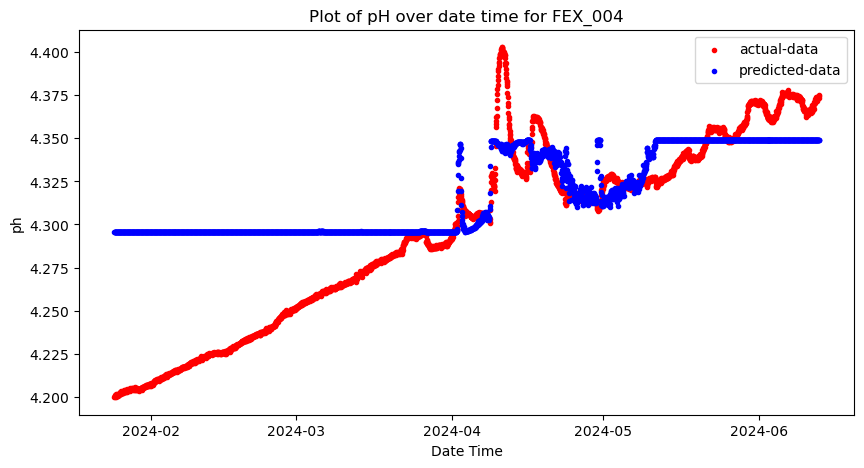

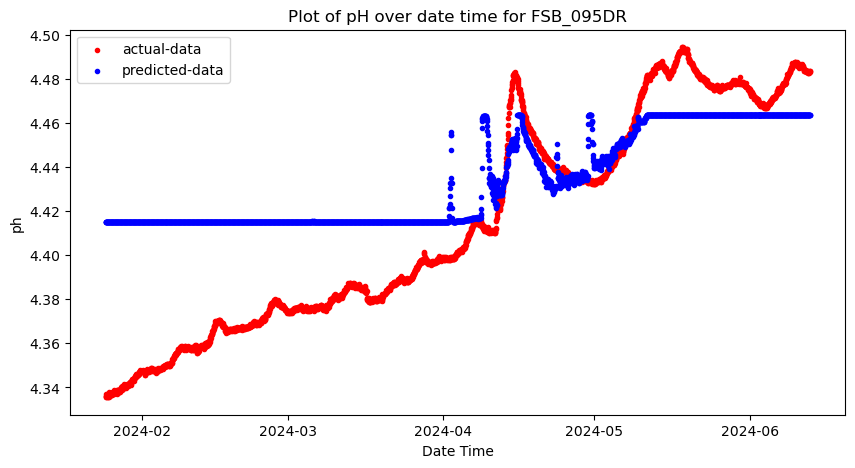

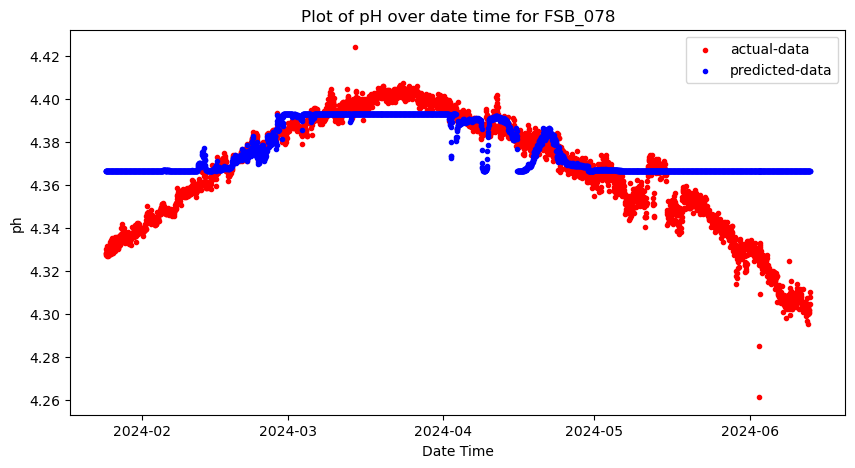

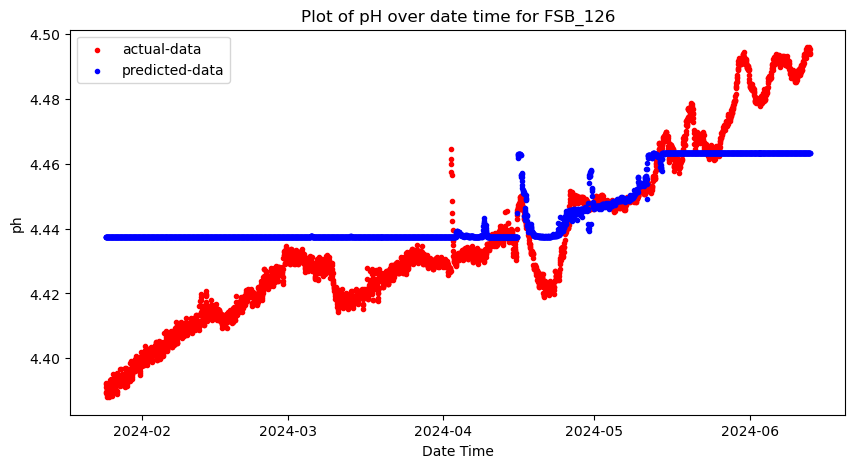

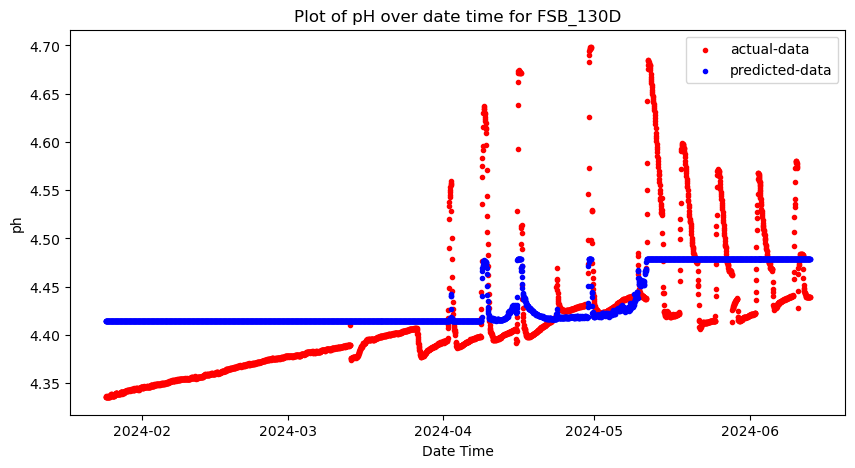

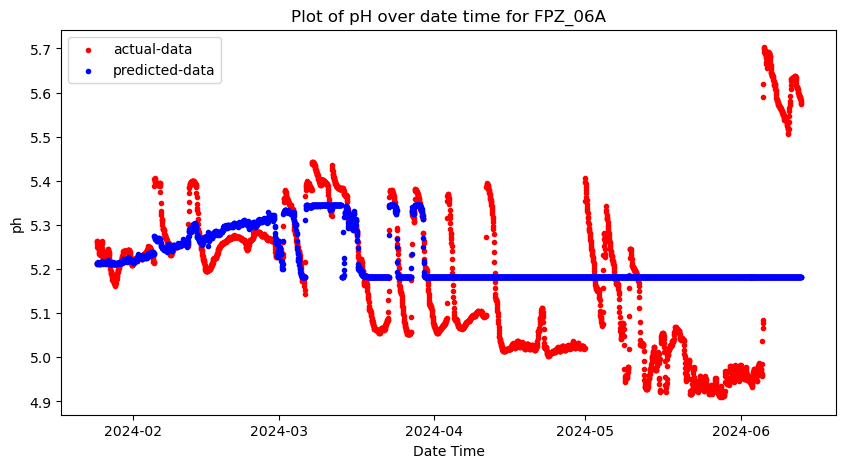

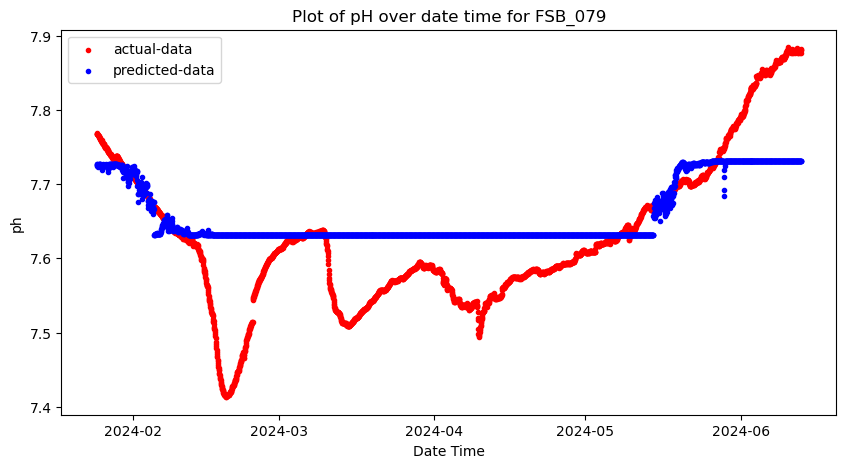

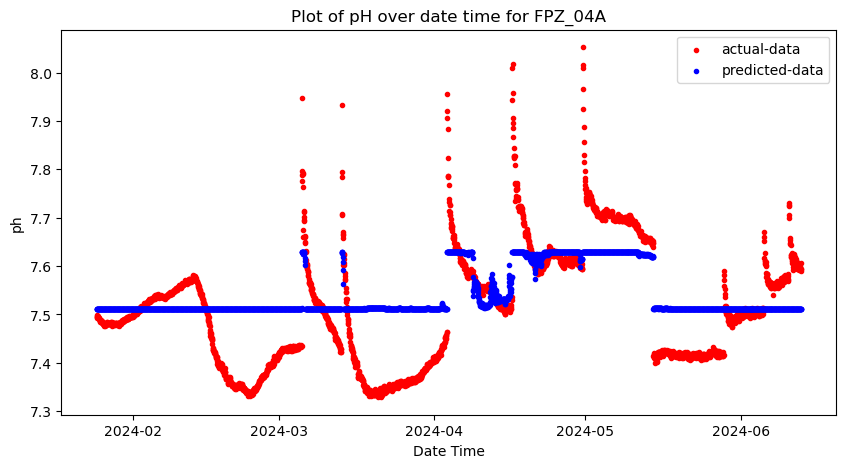

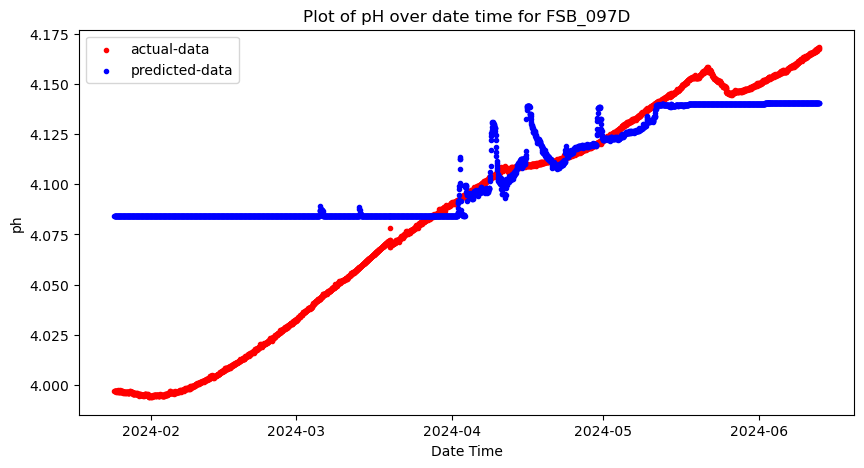

In [460]:
for index,station in enumerate(cols):
    
    plt.figure(figsize=(10, 5))
    # index = 0
    plt.scatter(df_interpolate["dt"], test_df[cols[index]], marker='.', color="red", label="actual-data")
    plt.scatter(df_interpolate["dt"], reversed_df[cols[index]], marker='.', color="blue", label = "predicted-data")


    plt.xlabel('Date Time')
    plt.ylabel('ph')
    plt.title(f'Plot of pH over date time for {cols[index]}')
    plt.legend()
    plt.show()